In [1]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
lr = 1e-2
epoch = int(1e3)
batch_size = 100

In [3]:
import tensorflow as tf
import numpy as np
import copy
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = copy.copy(y_train).astype(np.int32) 
y_test_cls = copy.copy(y_test).astype(np.int32)
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(y_train_cls.shape, y_test_cls.shape)

(60000, 784) (10000, 784)
(60000, 10) (10000, 10)
(60000,) (10000,)


In [4]:
activation = tf.nn.softsign

In [5]:
x = tf.placeholder(tf.float32, (None,784)) # (?, 784)
y = tf.placeholder(tf.float32, (None,10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)

b1 = tf.get_variable('b1', (100,), tf.float32, tf.keras.initializers.constant(0.0))
w1 = tf.get_variable('w1', (784,100), tf.float32, tf.keras.initializers.he_normal())

b2 = tf.get_variable('b2', (10,), tf.float32, tf.keras.initializers.constant(0.0))
w2 = tf.get_variable('w2', (100,10), tf.float32, tf.keras.initializers.he_normal())

x1 = activation(x @ w1 + b1) # (?,100) = (?,784) @ (784,100) + (100,) 
logits = x1 @ w2 + b2 # (?,10) = (?,100) @ (100,10) + (10,) 
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()
train = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)
print(logits.shape, entropy.shape, loss.shape)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), name='accuracy') # () float32
print(y_pred_cls.shape, correct_bool.shape, accuracy.shape)
print(y_pred_cls.dtype, correct_bool.dtype, accuracy.dtype)

(?, 10) (?,) ()
(?,) (?,) ()
<dtype: 'int32'> <dtype: 'bool'> <dtype: 'float32'>


In [6]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        for k in range(x_train.shape[0]//batch_size):
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            feed_dict = {x:x_batch, y:y_batch, y_cls:y_cls_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)

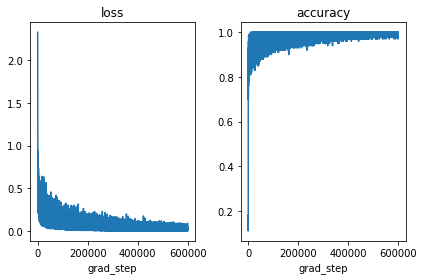

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [8]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.9782


In [9]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 971    0    1    1    1    2    1    1    2    0]
 [   0 1124    2    1    0    1    2    1    4    0]
 [   8    0 1002    2    3    1    5    3    8    0]
 [   0    0    4  988    0    5    0    4    2    7]
 [   2    0    4    0  959    1    4    1    0   11]
 [   5    1    1   10    1  866    5    1    1    1]
 [   6    2    2    1    2    3  940    0    2    0]
 [   1    0    8    5    1    0    0 1005    2    6]
 [   4    0    3    5    3    4    2    4  948    1]
 [   3    3    0    7    8    2    0    7    0  979]]


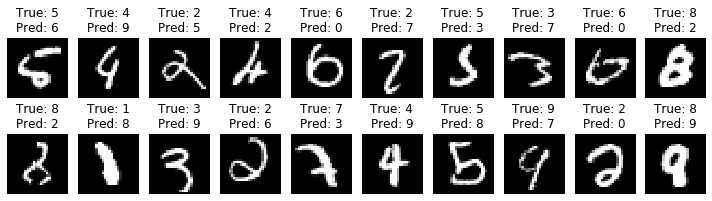

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 10, figsize=(10,3))
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.gray)
            ax.set_title('True: {}\nPred: {}'.format(y_test_cls[idx], y_test_cls_pred[idx]))
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()